# PyTorch로 딥러닝 제대로 배우기-중급
## Part3-2: 심층 신경망 실습
### 딥러닝 파이프 라인

1. 데이터 호출(Cifar-10)
2. 모델
3. 최적화 (Adam, SGD, RMSProp 사용)
4. 활성화 함수 (Sigmoid,Tanh)

### (1) 데이터 호출 (Cifar-10)

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
transform = Compose(
    [ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = datasets.CIFAR10( root='./dataset', 
                            train=True, 
                            download=True, 
                            transform=transform)
trainloader = DataLoader(trainset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=2)

testset = datasets.CIFAR10(
    root='./dataset', train=False, download=True, transform=transform)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:39<00:00, 4356694.46it/s]


Extracting ./dataset\cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### 시각화

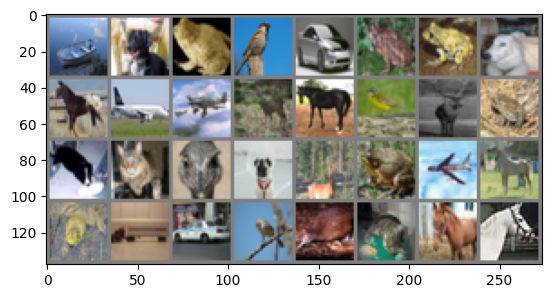

ship  dog   frog  bird  car   frog  frog  dog   horse plane plane deer  horse bird  deer  frog  dog   cat   bird  dog   deer  frog  plane horse frog  truck car   bird  bird  cat   horse horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### (2) 모델

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### (3) 최적화(Optimization)

#### 학습/평가 함수 정의

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Batch size 조절

In [8]:
batch_size = 64

trainloader = DataLoader(trainset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=2)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2)

#### SGD

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.299049  [    0/50000]
loss: 2.300320  [ 6400/50000]
loss: 2.286772  [12800/50000]
loss: 2.272858  [19200/50000]
loss: 2.272114  [25600/50000]
loss: 2.265325  [32000/50000]
loss: 2.272151  [38400/50000]
loss: 2.261244  [44800/50000]
Test Error: 
 Accuracy: 22.3%, Avg loss: 2.246274 

Epoch 2
-------------------------------
loss: 2.254896  [    0/50000]
loss: 2.243273  [ 6400/50000]
loss: 2.235395  [12800/50000]
loss: 2.226993  [19200/50000]
loss: 2.202925  [25600/50000]
loss: 2.207465  [32000/50000]
loss: 2.168725  [38400/50000]
loss: 2.205198  [44800/50000]
Test Error: 
 Accuracy: 25.9%, Avg loss: 2.177387 

Epoch 3
-------------------------------
loss: 2.187183  [    0/50000]
loss: 2.145980  [ 6400/50000]
loss: 2.145179  [12800/50000]
loss: 2.150937  [19200/50000]
loss: 2.144885  [25600/50000]
loss: 2.098851  [32000/50000]
loss: 2.147393  [38400/50000]
loss: 2.116601  [44800/50000]
Test Error: 
 Accuracy: 27.7%, Avg loss: 2.104795 

Epoc

#### Adam

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 1.936630  [    0/50000]
loss: 1.757830  [ 6400/50000]
loss: 1.992397  [12800/50000]
loss: 1.802723  [19200/50000]
loss: 1.642128  [25600/50000]
loss: 1.323928  [32000/50000]
loss: 1.469092  [38400/50000]
loss: 1.538481  [44800/50000]
Test Error: 
 Accuracy: 47.1%, Avg loss: 1.483600 

Epoch 2
-------------------------------
loss: 1.258258  [    0/50000]
loss: 1.544070  [ 6400/50000]
loss: 1.737589  [12800/50000]
loss: 1.351494  [19200/50000]
loss: 1.855282  [25600/50000]
loss: 1.590557  [32000/50000]
loss: 1.364005  [38400/50000]
loss: 1.280768  [44800/50000]
Test Error: 
 Accuracy: 48.9%, Avg loss: 1.451172 

Epoch 3
-------------------------------
loss: 1.406756  [    0/50000]
loss: 1.327581  [ 6400/50000]
loss: 1.249467  [12800/50000]
loss: 1.354151  [19200/50000]
loss: 1.323365  [25600/50000]
loss: 0.977036  [32000/50000]
loss: 1.388170  [38400/50000]
loss: 1.204661  [44800/50000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.390657 

Epoc

#### RMSProp

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [14]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 0.964094  [    0/50000]
loss: 1.049900  [ 6400/50000]
loss: 1.204869  [12800/50000]
loss: 1.000380  [19200/50000]
loss: 1.164858  [25600/50000]
loss: 0.922553  [32000/50000]
loss: 1.076844  [38400/50000]
loss: 1.212399  [44800/50000]
Test Error: 
 Accuracy: 50.5%, Avg loss: 1.518754 

Epoch 2
-------------------------------
loss: 1.031260  [    0/50000]
loss: 0.856372  [ 6400/50000]
loss: 0.961966  [12800/50000]
loss: 0.810469  [19200/50000]
loss: 1.318655  [25600/50000]
loss: 0.830767  [32000/50000]
loss: 1.203988  [38400/50000]
loss: 0.796204  [44800/50000]
Test Error: 
 Accuracy: 50.9%, Avg loss: 1.583287 

Epoch 3
-------------------------------
loss: 0.977667  [    0/50000]
loss: 0.861544  [ 6400/50000]
loss: 0.863291  [12800/50000]
loss: 0.624958  [19200/50000]
loss: 0.956885  [25600/50000]
loss: 1.074748  [32000/50000]
loss: 0.900165  [38400/50000]
loss: 0.842466  [44800/50000]
Test Error: 
 Accuracy: 50.5%, Avg loss: 1.746936 

Epoc

### (4) Activation Functions

#### Sigmoid

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_sigmoid_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.Sigmoid(),
        nn.Linear(512, 512),
        nn.Sigmoid(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_sigmoid_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [17]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.372850  [    0/50000]
loss: 1.925460  [ 6400/50000]
loss: 1.825508  [12800/50000]
loss: 1.879373  [19200/50000]
loss: 1.638474  [25600/50000]
loss: 1.446603  [32000/50000]
loss: 1.719444  [38400/50000]
loss: 1.637637  [44800/50000]
Test Error: 
 Accuracy: 40.0%, Avg loss: 1.677732 

Epoch 2
-------------------------------
loss: 1.482369  [    0/50000]
loss: 1.732737  [ 6400/50000]
loss: 1.442490  [12800/50000]
loss: 1.489789  [19200/50000]
loss: 1.473231  [25600/50000]
loss: 1.420338  [32000/50000]
loss: 1.414012  [38400/50000]
loss: 1.613256  [44800/50000]
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.508634 

Epoch 3
-------------------------------
loss: 1.180224  [    0/50000]
loss: 1.555475  [ 6400/50000]
loss: 1.149443  [12800/50000]
loss: 1.424239  [19200/50000]
loss: 1.482257  [25600/50000]
loss: 1.363347  [32000/50000]
loss: 1.533830  [38400/50000]
loss: 1.362601  [44800/50000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.475939 

Epoc

#### tahn

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_tanh_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.Tanh(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_tanh_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [20]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.315269  [    0/50000]
loss: 1.734386  [ 6400/50000]
loss: 1.936143  [12800/50000]
loss: 1.875829  [19200/50000]
loss: 1.784739  [25600/50000]
loss: 1.848695  [32000/50000]
loss: 1.680748  [38400/50000]
loss: 1.767936  [44800/50000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 1.808640 

Epoch 2
-------------------------------
loss: 1.619055  [    0/50000]
loss: 1.419362  [ 6400/50000]
loss: 1.802259  [12800/50000]
loss: 1.681832  [19200/50000]
loss: 1.746377  [25600/50000]
loss: 1.470958  [32000/50000]
loss: 1.413126  [38400/50000]
loss: 1.532565  [44800/50000]
Test Error: 
 Accuracy: 40.5%, Avg loss: 1.722013 

Epoch 3
-------------------------------
loss: 1.680193  [    0/50000]
loss: 1.493859  [ 6400/50000]
loss: 1.391518  [12800/50000]
loss: 1.469716  [19200/50000]
loss: 1.507345  [25600/50000]
loss: 1.396622  [32000/50000]
loss: 1.408412  [38400/50000]
loss: 1.350037  [44800/50000]
Test Error: 
 Accuracy: 43.5%, Avg loss: 1.636470 

Epoc